---
**License**

 ccl_power

 Fri Jul 17 11:15:00 2023\
 Copyright  2023\
 Mariana Penna-Lima pennalima@unb.br Pedro Henrique Costa Ribeiro pedrohenriquecostaribeiro@gmail.com Vinicius dos Santos Bessa Ribeiro viniciusbessa@on.br Sandro Vitenti vitenti@uel.br

---
---

 ccl_power\
 Copyright (C) 2023 Mariana Penna-Lima <pennalima@unb.br> Pedro Henrique Costa Ribeiro <pedrohenriquecostaribeiro@gmail.com> Vinicius dos Santos Bessa Ribeiro <viniciusbessa@on.br> Sandro Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.

---

---

# Comparison Notebook: CCL - Power module

---

In [1]:
# NumCosmo
from numcosmo_py import Nc, Ncm
from numcosmo_py.ccl.nc_ccl import create_nc_obj, CCLParams, dsigmaM_dlnM
from numcosmo_py.ccl.comparison import compare_ccl_nc_func

# CCL
import pyccl as ccl

import sys
import numpy as np
import math
import matplotlib.pyplot as plt

import scipy 

%matplotlib inline

### Starting NumCosmo

First, we have to iniciate the NumCosmo configuration, and redirect it's outputs to this notebook.

In [2]:
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

### Defining initial quantities

Before creating the comparison functions, we must create all the necessary global variables and atribute their initial values.

In [3]:
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
A_s = 2.1e-9
n_s = 0.96
Neff = 0.0
sigma8 = 0.9
mu_0 = 0.1
sigma_0 = 0.1

Omega_v_vals = np.array([0.7, 0.7, 0.7, 0.65, 0.75])
w0_vals = np.array([-1.0, -0.9, -0.9, -0.9, -0.9])
wa_vals = np.array([0.0, 0.0, 0.1, 0.1, 0.1])

mnu = [[0.04, 0.0, 0.0], [0.05, 0.01, 0.0], [0.05, 0.0, 0.0], [0.03, 0.02, 0.0]]
Neff_mnu = 3.0

### Table of variables

Simple explanation of the values defined above.


| Var. Name |    Quantity     |
|   :----:  |     :----:      |
|  Omega_c  | Cold Dark Matter Density |
|  Omega_b  | Baryonic Matter Density  |
|  Omega_v  | Dark Energy Density |
|  Omega_k  | Curvature Density |
|     h     |    Hubble Constant (dimensionless)   |
|    A_s    | Power spectrum normalization |
|    n_s    | Adiabatic scalar spectral index |
|    Neff   | Effective Nº of massless neutrinos present |
|   sigma8  | Variance of matter density perturbations*|
|    mu_0   | parameter of the mu-Sigma modified gravity model|
|  sigma_0  | parameter of the mu-Sigma modified gravity model|
|    w0     | parameter of the DE equation of state|
|    wa     | parameter of the DE equation of state|
|    mnu    | Total mass in eV of the massive neutrinos |


\* at an 8 Mpc/h scale

---

### 1) Matter Power Spectrum

This function will compare the linear and non linear matter power spectrum.

In [7]:
def compare_ps(k, z, Omega_v, w0, wa):
    """
    Compare the power spectrum 'pk' calculated by CCL and by NumCosmo.
    This test is only valid when massive neutrinos are set to zero (ccl default parameter: mnu = 0.0).
    """

    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        sigma8=sigma8,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    nc_cosmo = create_nc_obj(ccl_cosmo)
    cosmo = nc_cosmo.cosmo
    ps_ml = nc_cosmo.ps_ml
    ps_mnl = nc_cosmo.ps_mnl

    for z_i in z:
        a_i = 1.0 / (1.0 + z_i)

        # linear matter power
        pk_ccl = ccl.linear_matter_power(ccl_cosmo, k, a_i)
        pk_nc = np.array([ps_ml.eval(cosmo, z_i, k_i) for k_i in k])
        compare_ccl_nc_func(
            k, pk_ccl, pk_nc, x_name="k", y_name="P_k(%.2f)" % z_i, xscale="log"
        )

        # non-linear matter power
        pnl_ccl = ccl.power.nonlin_matter_power(ccl_cosmo, k, a_i)
        pnl_nc = np.array([ps_mnl.eval(cosmo, z_i, k_i) for k_i in k])
        compare_ccl_nc_func(
            k, pnl_ccl, pnl_nc, x_name="k", y_name="P_nl(%.2f)" % z_i, xscale="log"
        )

        # kNL
        def integ(x):
            y = ps_ml.eval(cosmo, z_i, x)
            return y

        pkint = scipy.integrate.quad(integ, k[0], k[-1])

        pknl_ccl = ccl.power.kNL(ccl_cosmo, a_i)
        pknl_nc = ((1 / (6 * math.pi**2)) * pkint[0]) ** (-1 / 2)

        print(
            f"\nkNL_ccl: {pknl_ccl}  /  kNL_nc: {pknl_nc}  /  diff: {abs(pknl_ccl-pknl_nc)}\n"
        )

    ccl.gsl_params.reload()
    ccl.spline_params.reload()

--------------------------------------------------------------------------------
[P_k(0.00) ]: rel diff min: 1.47361012e-11	rel diff max: 4.28983948e-09
[P_nl(0.00)]: rel diff min: 2.70428124e-12	rel diff max: 7.07913261e-09

kNL_ccl: 0.1072528818948373  /  kNL_nc: 0.10725288969836796  /  diff: 7.803530668870629e-09

[P_k(0.50) ]: rel diff min: 1.61211045e-10	rel diff max: 7.07435122e-09
[P_nl(0.50)]: rel diff min: 2.17067120e-09	rel diff max: 5.16172693e-09

kNL_ccl: 0.13871427715541784  /  kNL_nc: 0.13871428744114989  /  diff: 1.0285732043868734e-08

[P_k(1.00) ]: rel diff min: 5.20516963e-11	rel diff max: 5.76199510e-09
[P_nl(1.00)]: rel diff min: 1.60738090e-12	rel diff max: 7.56233209e-09

kNL_ccl: 0.17529721774612342  /  kNL_nc: 0.17529723062947244  /  diff: 1.2883349026493462e-08

--------------------------------------------------------------------------------



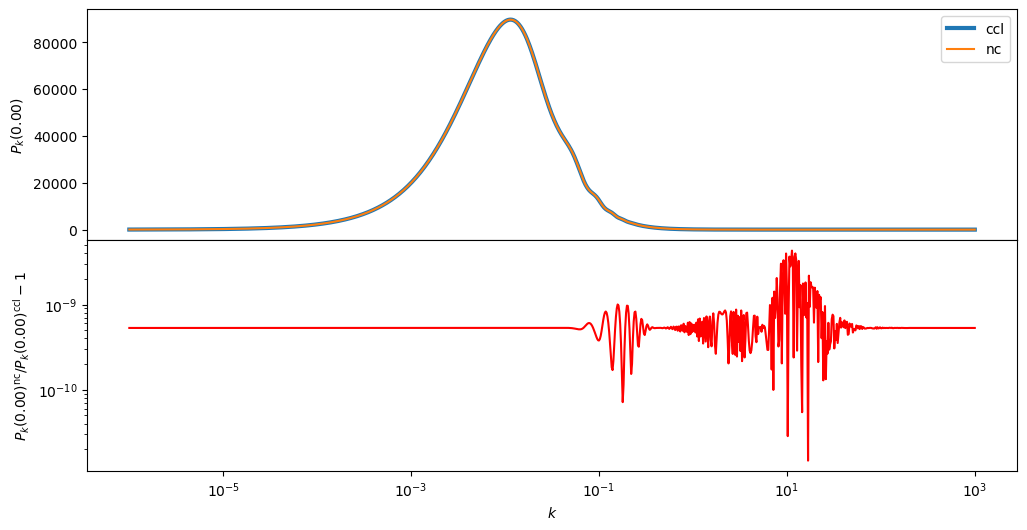

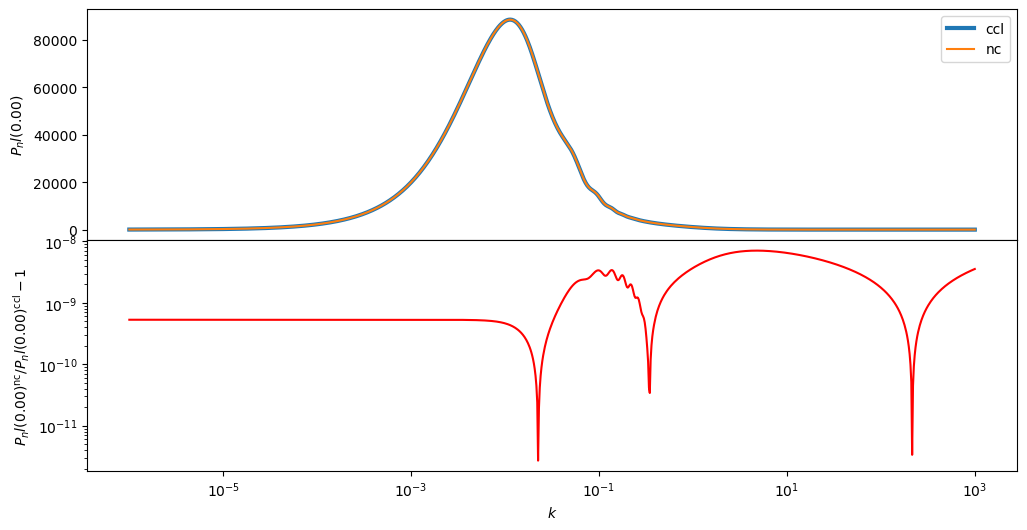

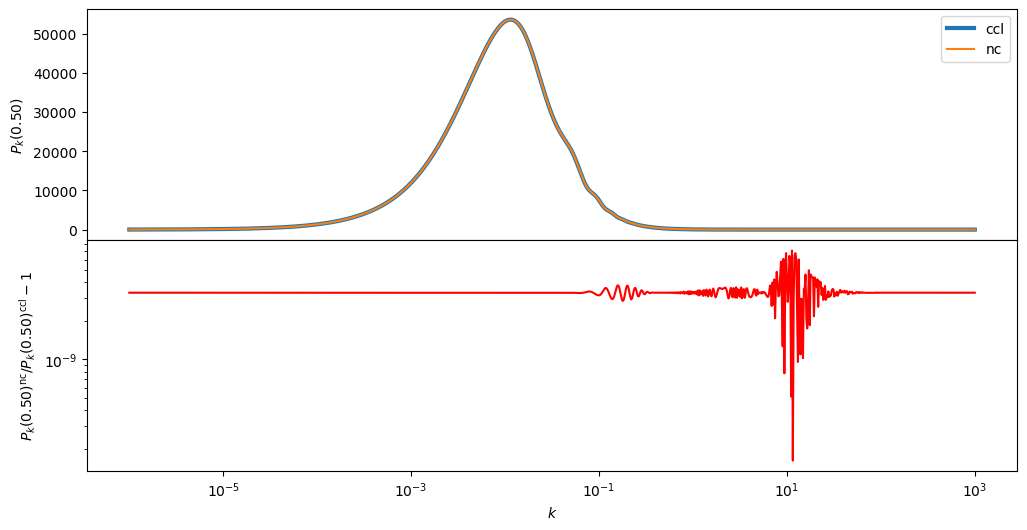

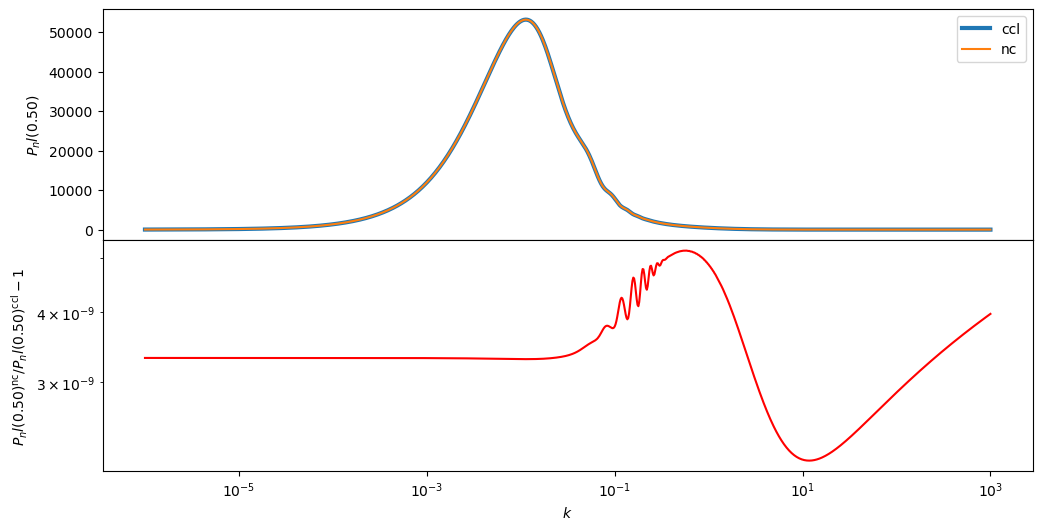

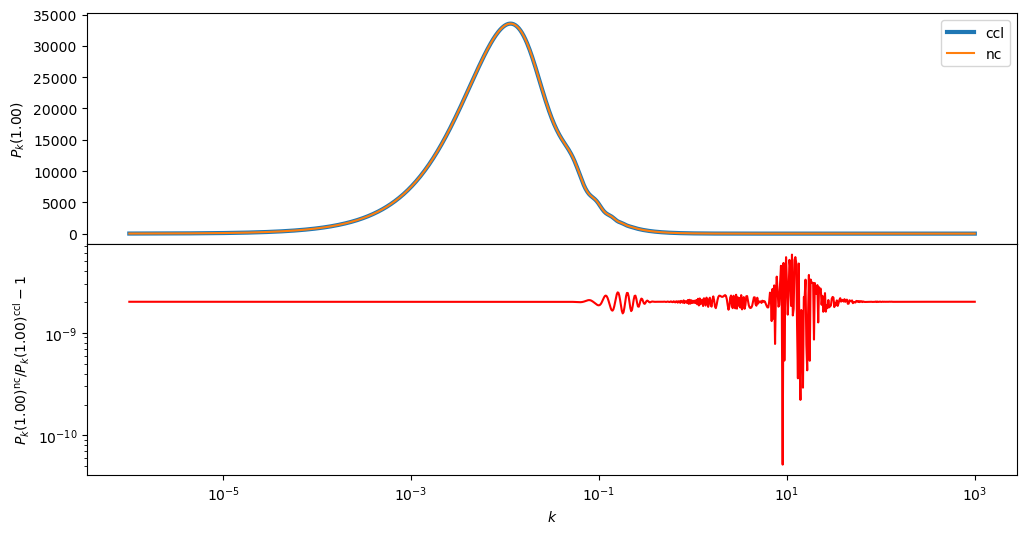

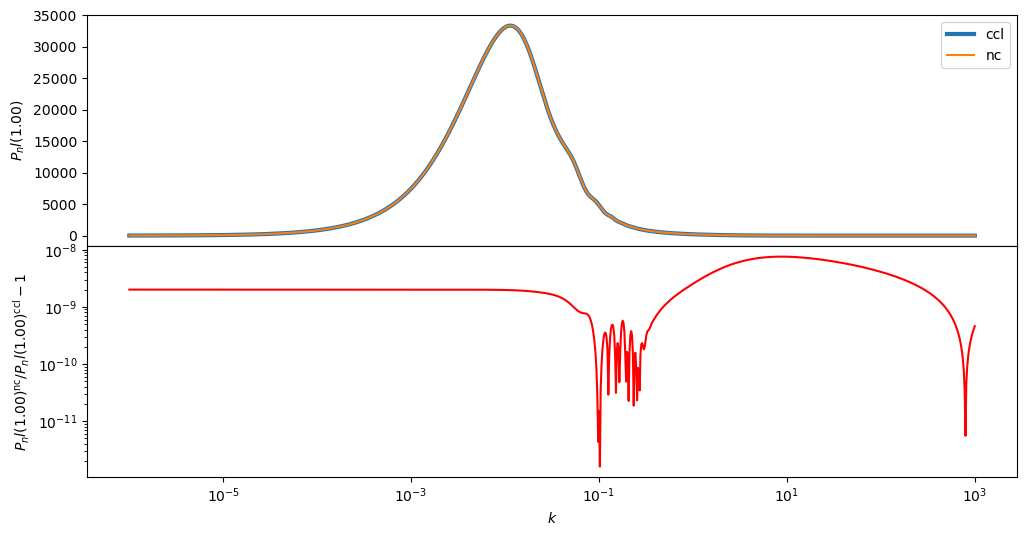


--------------------------------------------------------------------------------
[P_k(0.00) ]: rel diff min: 6.50321123e-08	rel diff max: 6.53514786e-04
[P_nl(0.00)]: rel diff min: 5.99567316e-07	rel diff max: 8.19327320e-04

kNL_ccl: 0.107253146604336  /  kNL_nc: 0.10725288969836794  /  diff: 2.569059680684882e-07

[P_k(0.50) ]: rel diff min: 1.52329746e-07	rel diff max: 6.53733888e-04
[P_nl(0.50)]: rel diff min: 2.13103450e-07	rel diff max: 7.60595810e-04

kNL_ccl: 0.13797127811124302  /  kNL_nc: 0.13797096275011334  /  diff: 3.1536112968244545e-07

[P_k(1.00) ]: rel diff min: 2.35368512e-07	rel diff max: 6.53816872e-04
[P_nl(1.00)]: rel diff min: 8.69750494e-10	rel diff max: 7.22594495e-04

kNL_ccl: 0.17313693450858114  /  kNL_nc: 0.17313654595778885  /  diff: 3.8855079229072054e-07

--------------------------------------------------------------------------------



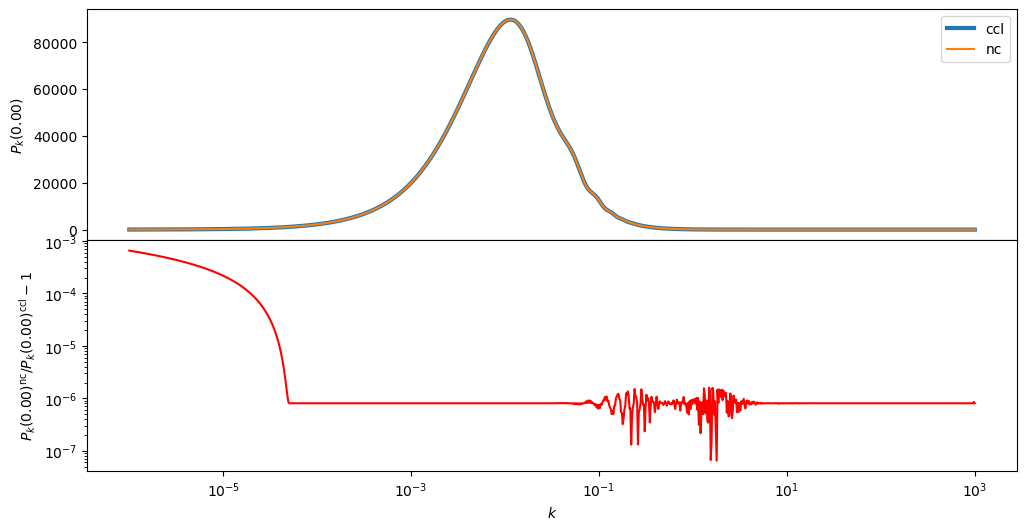

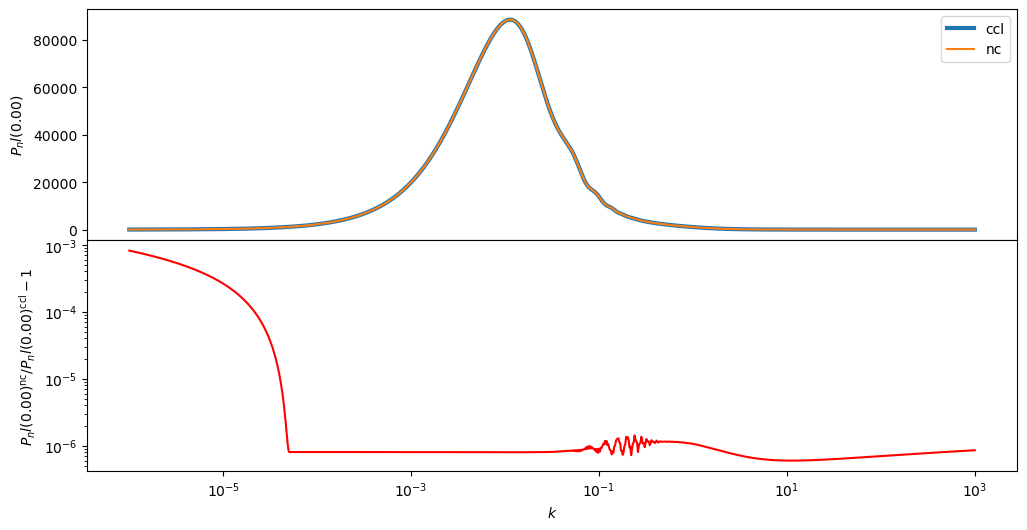

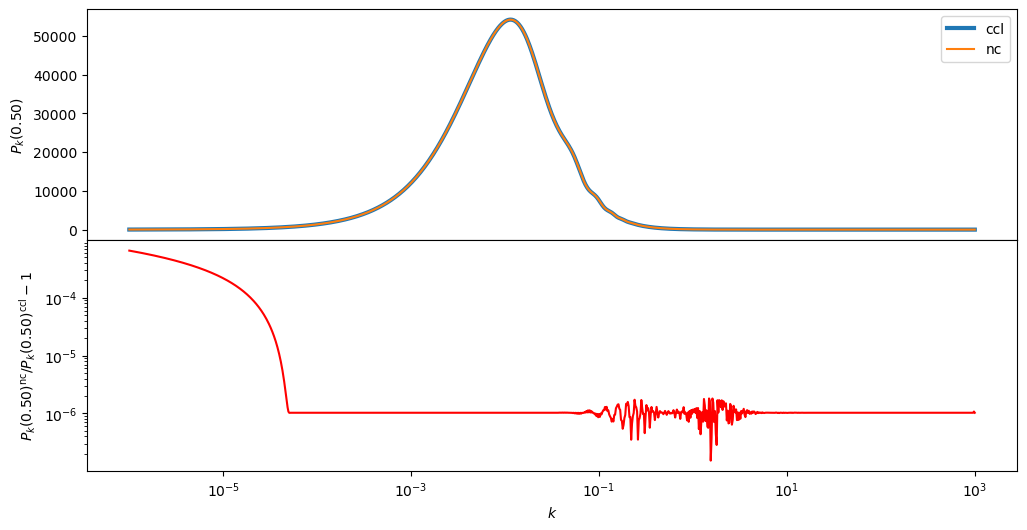

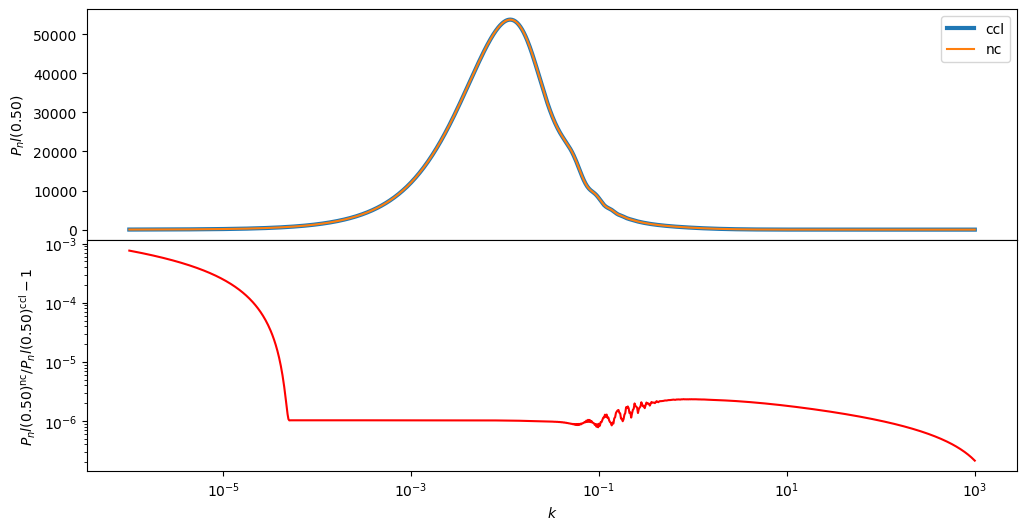

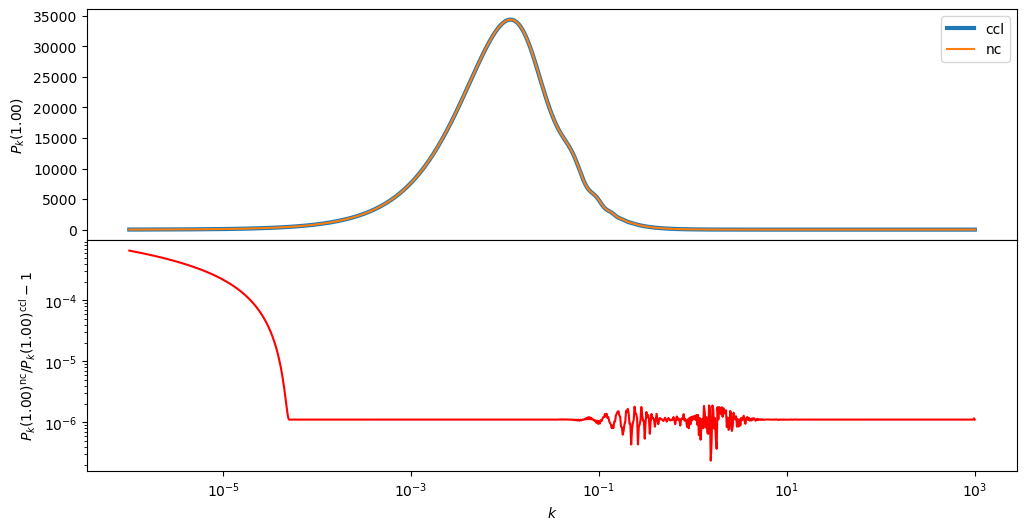

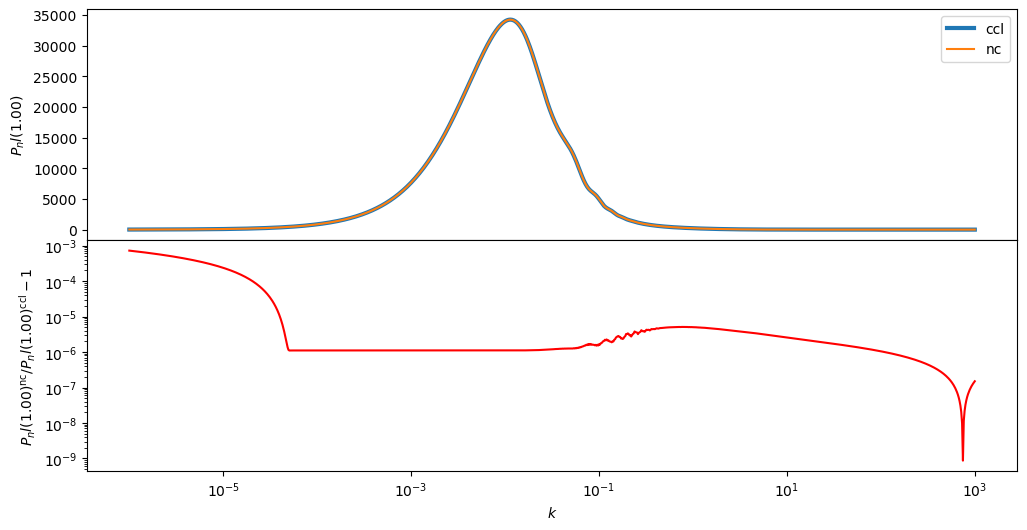


--------------------------------------------------------------------------------
[P_k(0.00) ]: rel diff min: 6.50321149e-08	rel diff max: 6.53514786e-04
[P_nl(0.00)]: rel diff min: 5.99567314e-07	rel diff max: 8.19327320e-04

kNL_ccl: 0.10725314660433576  /  kNL_nc: 0.10725288969836794  /  diff: 2.56905967818688e-07

[P_k(0.50) ]: rel diff min: 1.24248912e-07	rel diff max: 6.53705825e-04
[P_nl(0.50)]: rel diff min: 4.89565166e-09	rel diff max: 5.97261123e-03

kNL_ccl: 0.13785819679349362  /  kNL_nc: 0.13785787975525188  /  diff: 3.1703824174278417e-07

[P_k(1.00) ]: rel diff min: 2.15960189e-07	rel diff max: 6.53797477e-04
[P_nl(1.00)]: rel diff min: 1.75353043e-09	rel diff max: 5.56245123e-03

kNL_ccl: 0.17268161238271099  /  kNL_nc: 0.1726812231780177  /  diff: 3.8920469327963225e-07

--------------------------------------------------------------------------------



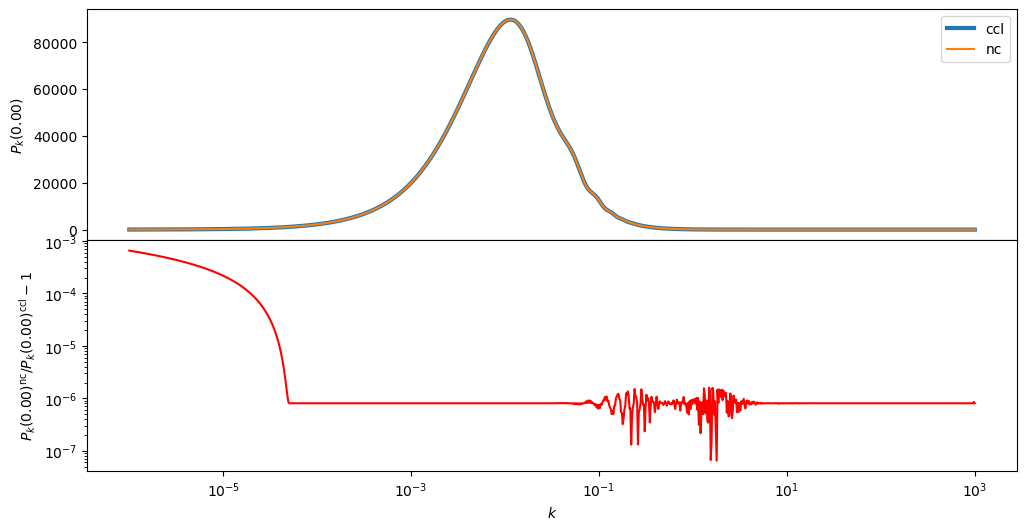

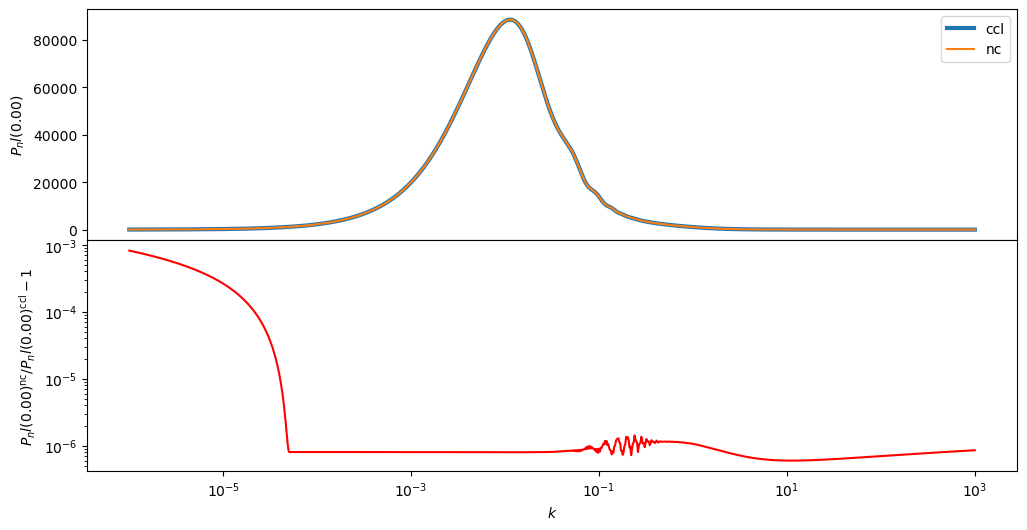

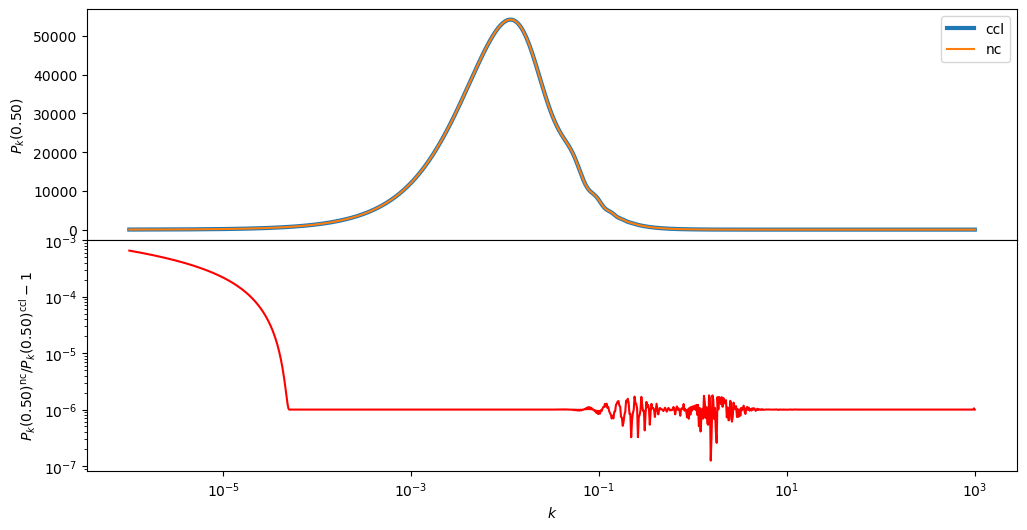

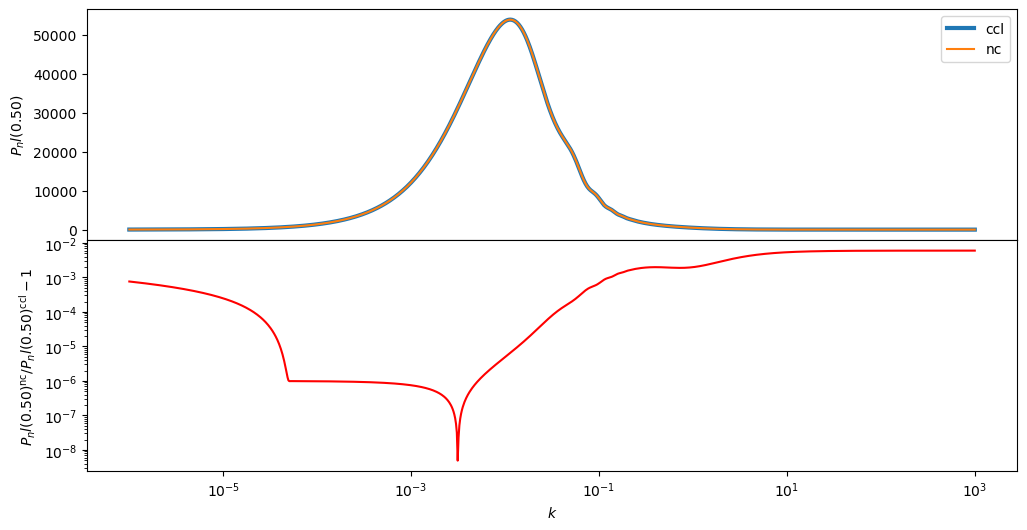

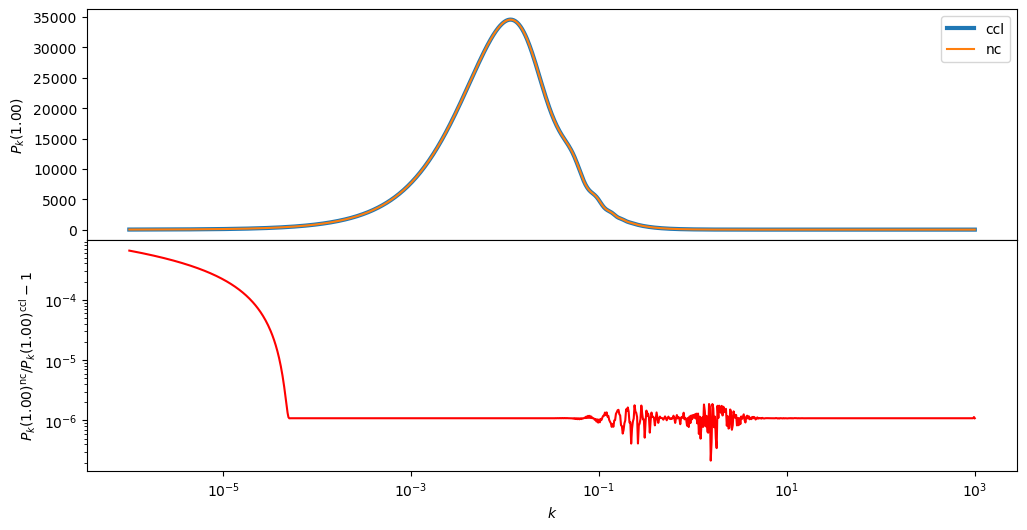

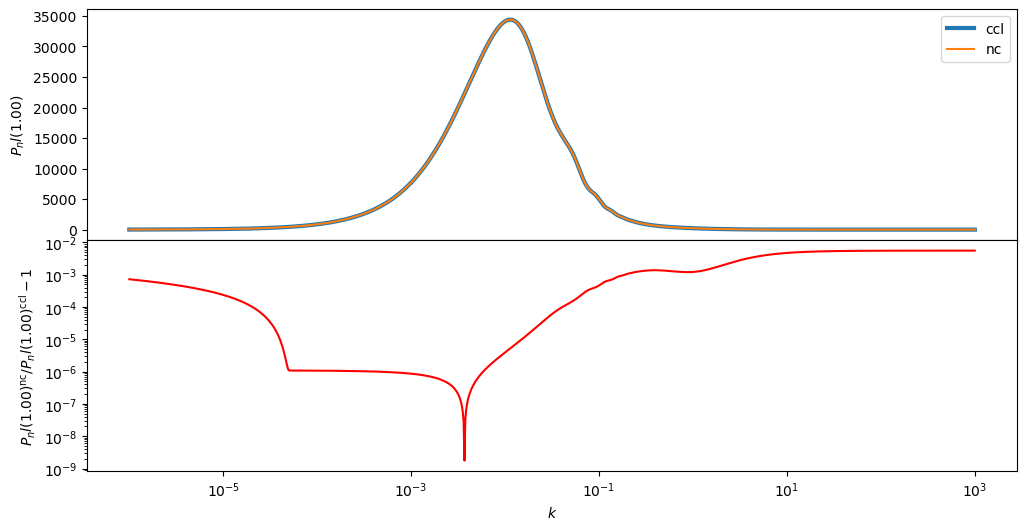


--------------------------------------------------------------------------------
[P_k(0.00) ]: rel diff min: 6.50321110e-08	rel diff max: 6.53514786e-04
[P_nl(0.00)]: rel diff min: 6.07961864e-07	rel diff max: 8.19597549e-04

kNL_ccl: 0.10725314660433596  /  kNL_nc: 0.10725288969836791  /  diff: 2.569059680546104e-07

[P_k(0.50) ]: rel diff min: 8.56714794e-08	rel diff max: 6.53667273e-04
[P_nl(0.50)]: rel diff min: 8.40466519e-09	rel diff max: 5.38147031e-03

kNL_ccl: 0.13744860575289422  /  kNL_nc: 0.13744828700540476  /  diff: 3.1874748945837084e-07

[P_k(1.00) ]: rel diff min: 1.56557613e-07	rel diff max: 6.53738113e-04
[P_nl(1.00)]: rel diff min: 2.73345790e-09	rel diff max: 4.96408609e-03

kNL_ccl: 0.17133343935868123  /  kNL_nc: 0.17133304810380312  /  diff: 3.912548781070946e-07

--------------------------------------------------------------------------------



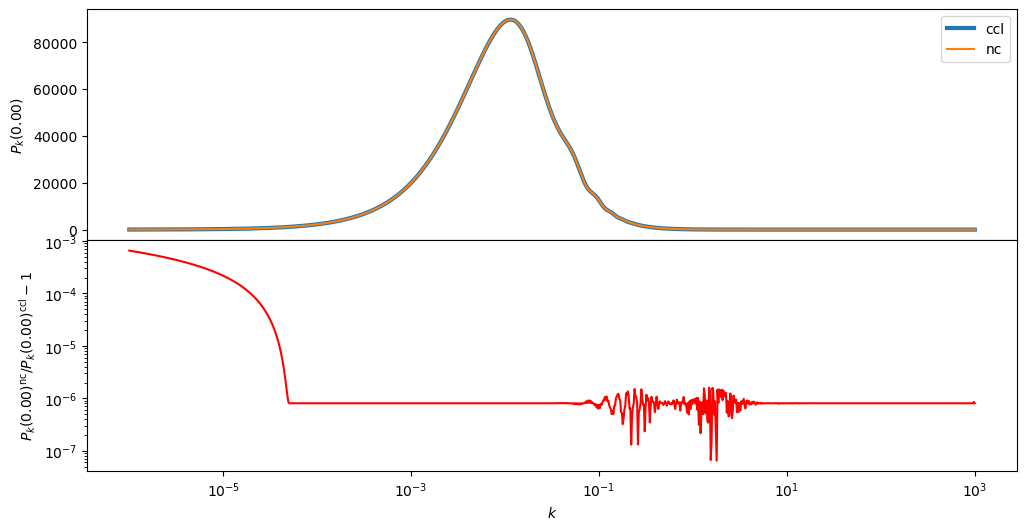

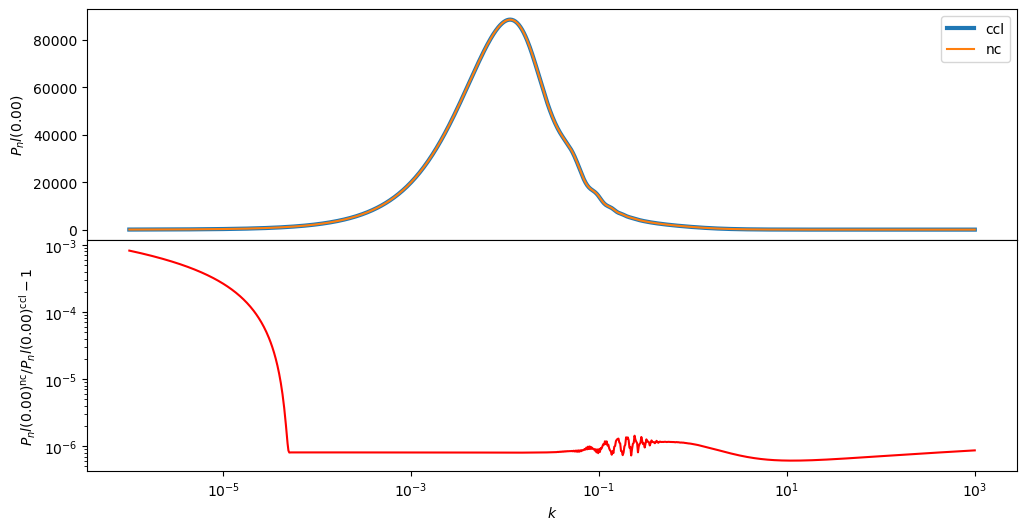

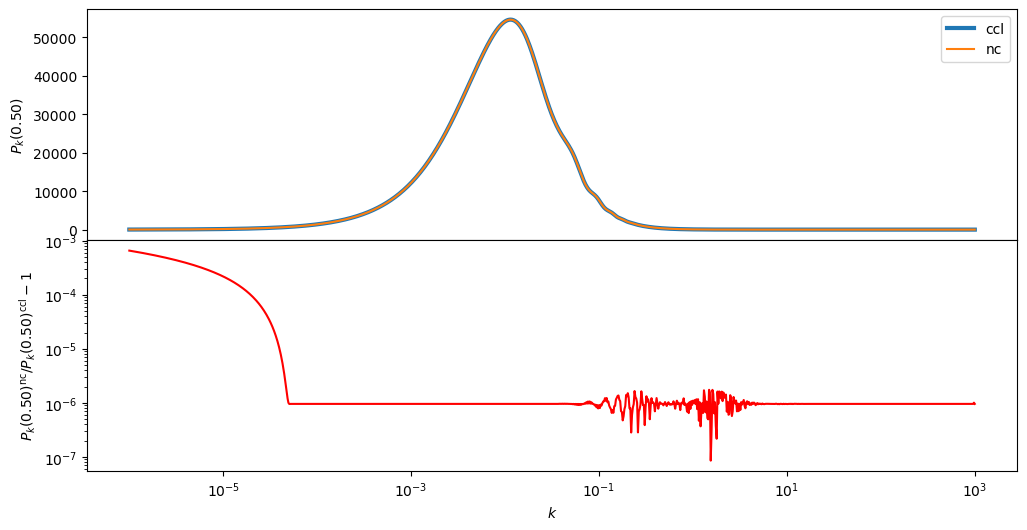

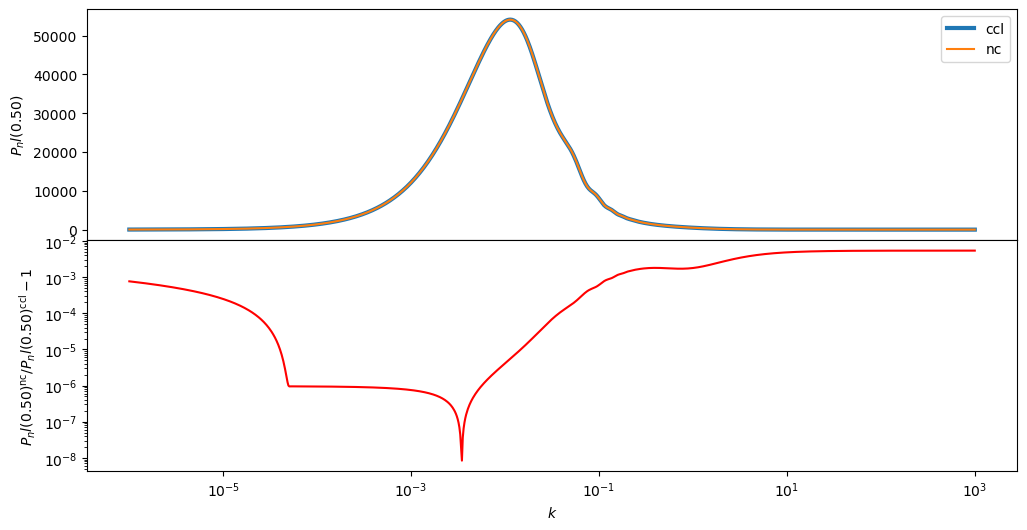

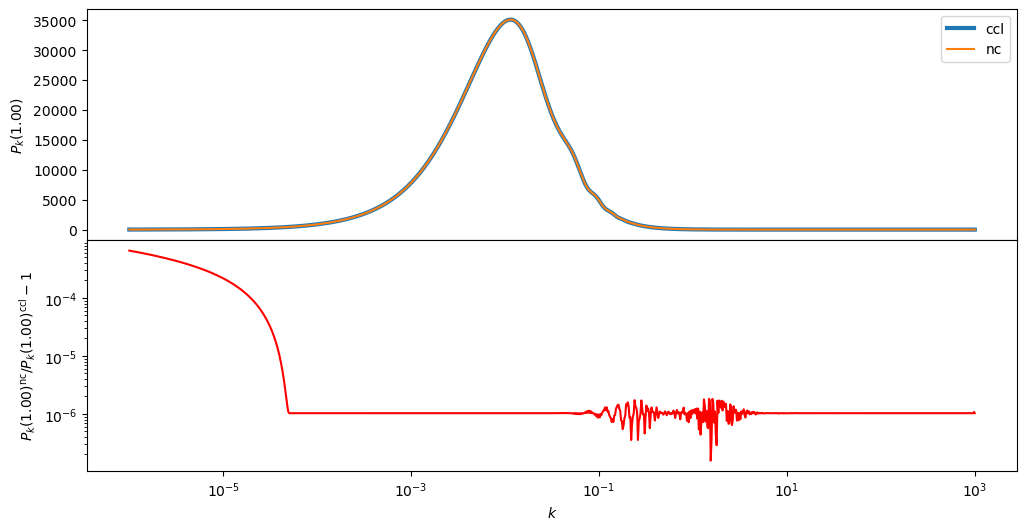

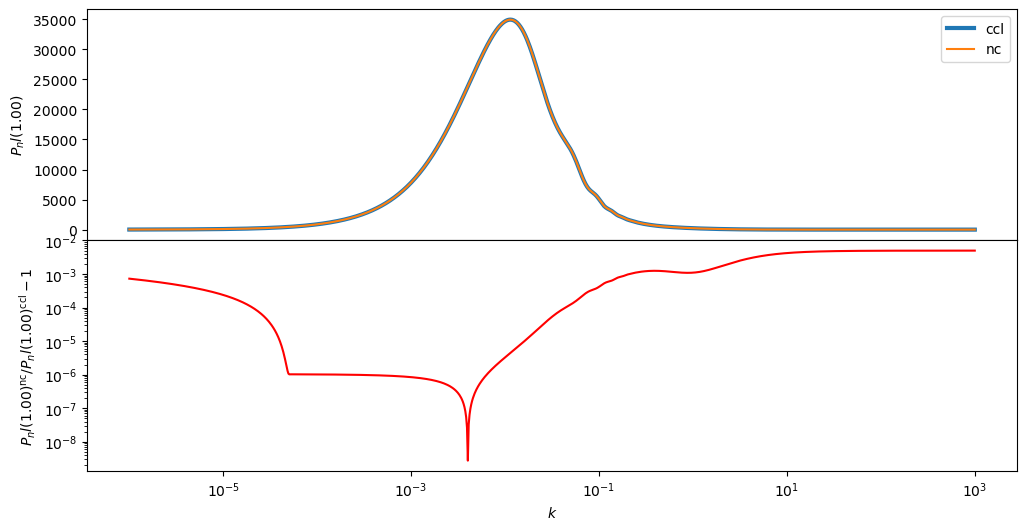


--------------------------------------------------------------------------------
[P_k(0.00) ]: rel diff min: 6.50321139e-08	rel diff max: 6.53514786e-04
[P_nl(0.00)]: rel diff min: 5.91197634e-07	rel diff max: 8.19033077e-04

kNL_ccl: 0.10725314660433587  /  kNL_nc: 0.10725288969836785  /  diff: 2.5690596801297705e-07

[P_k(0.50) ]: rel diff min: 1.28091333e-07	rel diff max: 6.53709665e-04
[P_nl(0.50)]: rel diff min: 5.90226579e-09	rel diff max: 6.60007710e-03

kNL_ccl: 0.13828360934672826  /  kNL_nc: 0.1382832915958187  /  diff: 3.177509095564357e-07

[P_k(1.00) ]: rel diff min: 2.34112874e-07	rel diff max: 6.53815617e-04
[P_nl(1.00)]: rel diff min: 1.16186936e-08	rel diff max: 6.21218003e-03

kNL_ccl: 0.17410847524323464  /  kNL_nc: 0.17410808440281972  /  diff: 3.908404149211009e-07

--------------------------------------------------------------------------------



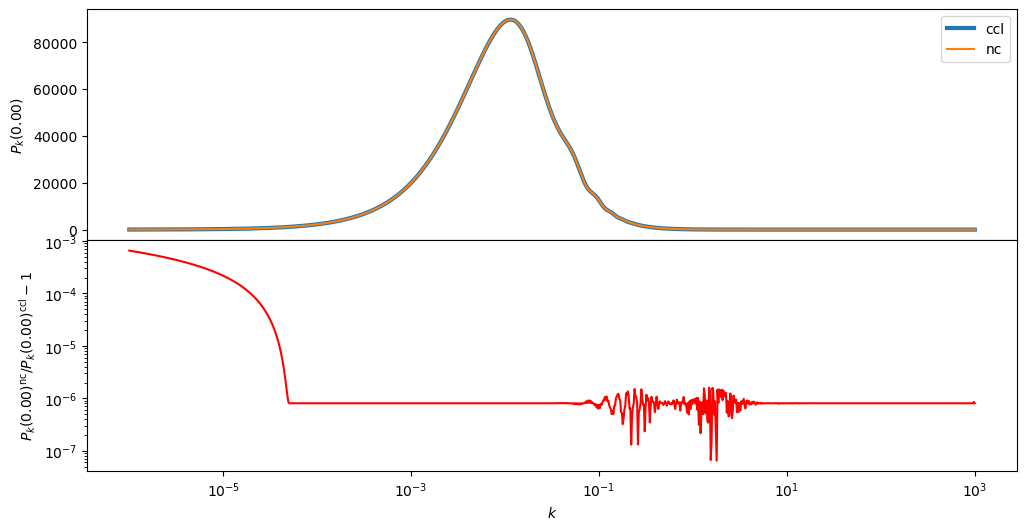

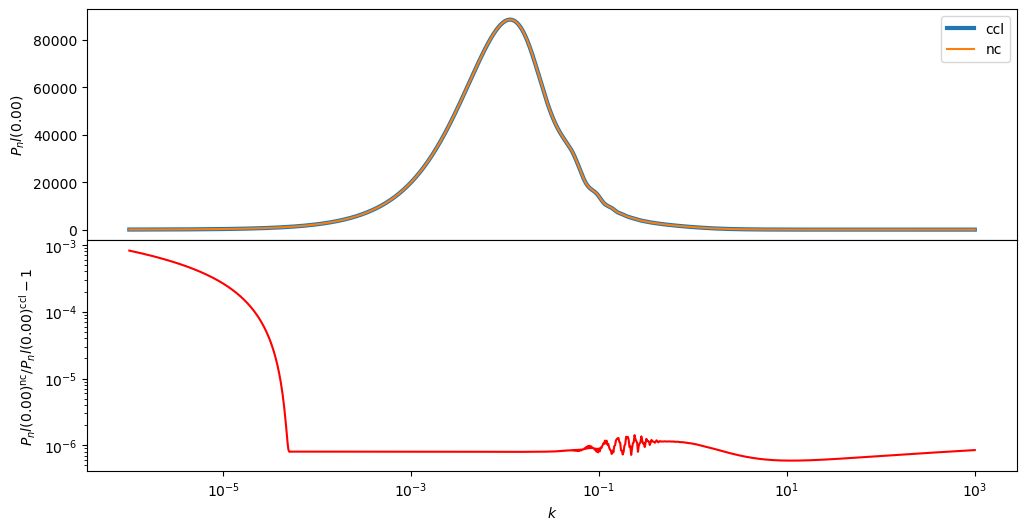

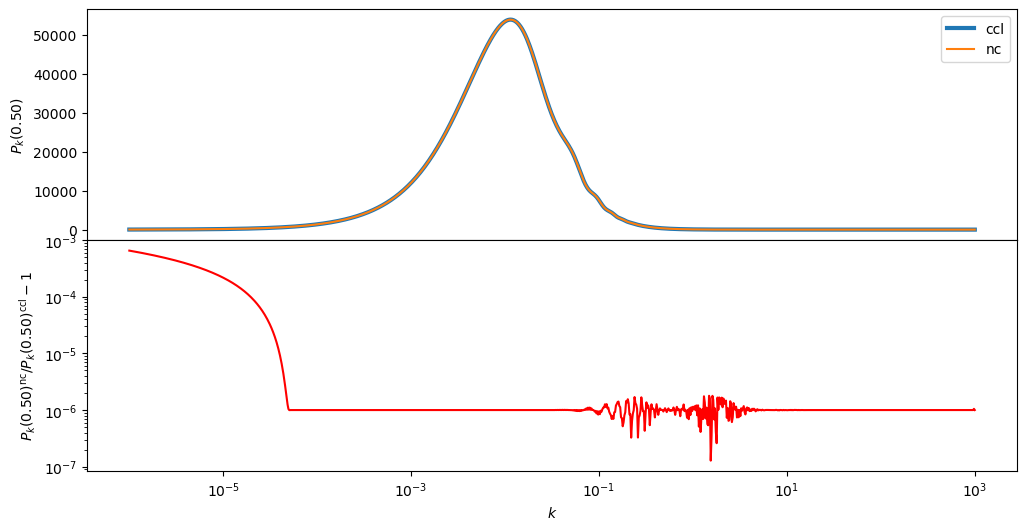

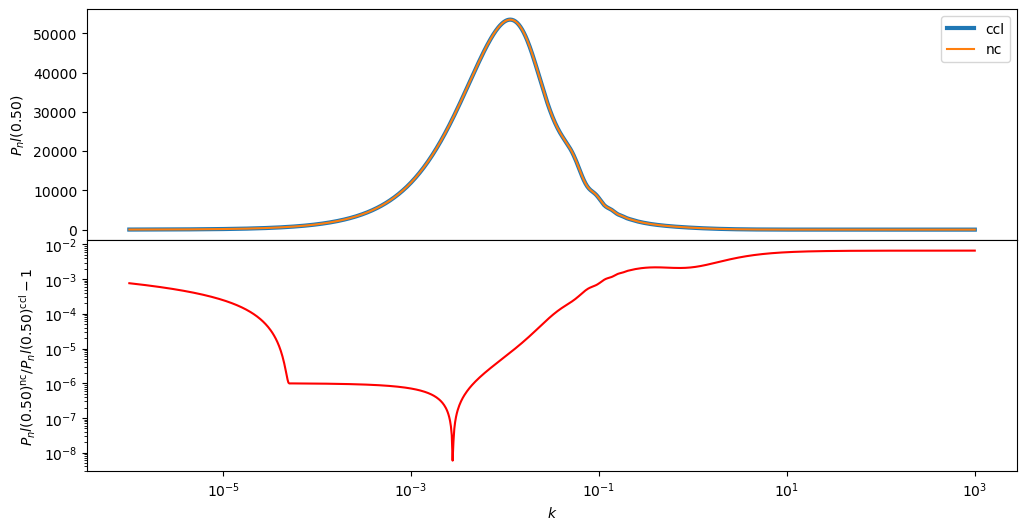

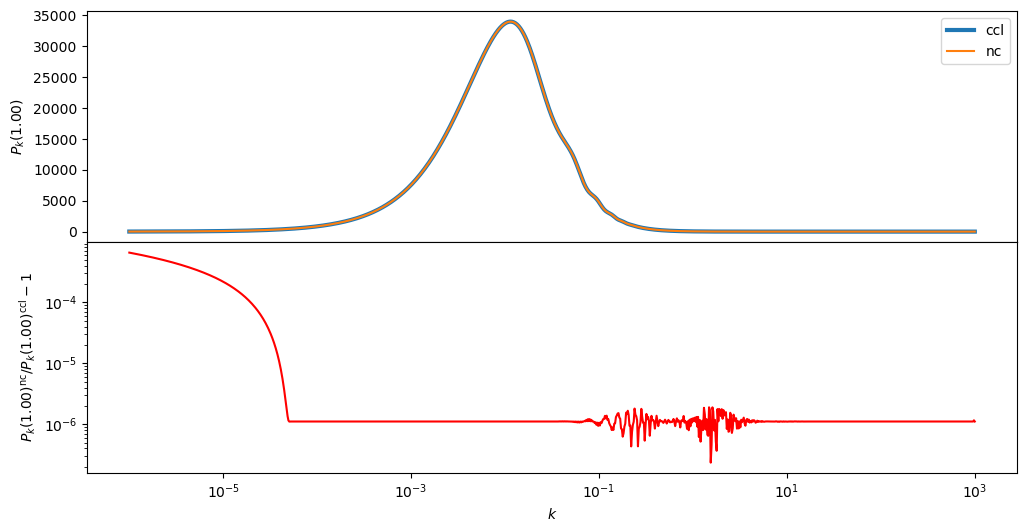

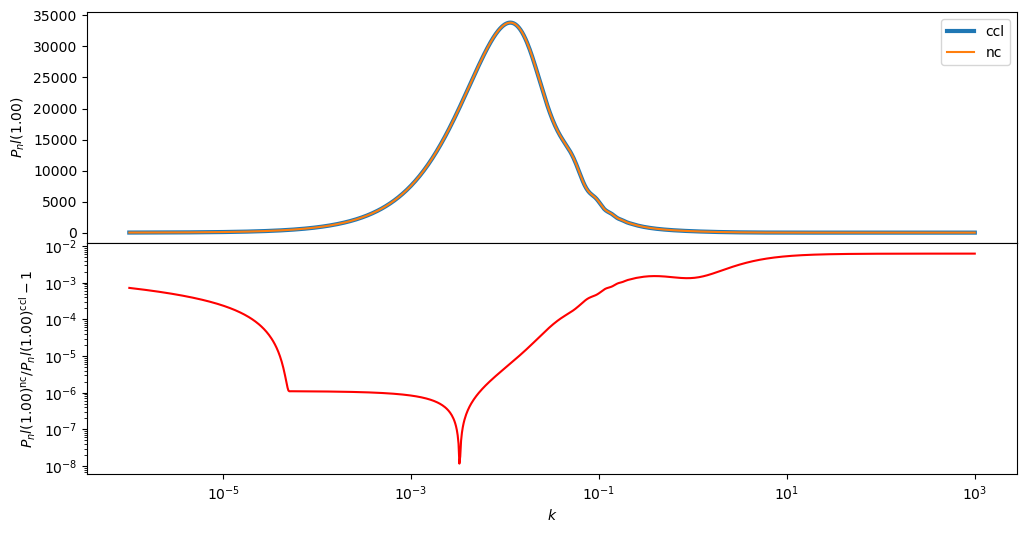

In [8]:
k = np.geomspace(1.0e-6, 1.0e3, 1000)
z = [0.0, 0.5, 1.0]

for i in range(5):
    print("-" * 80)
    compare_ps(k, z, Omega_v_vals[i], w0_vals[i], wa_vals[i])
    print("-" * 80 + "\n")

    plt.show()
    plt.close()  # It's faster to close figures in each loop
    print()

# compare_ps (k, z, 0.7, -1.0, 0.0)

#### 1.1) Time Comparison

We compare the time spent on calculating the power spectrum.

In [9]:
# z_i = 0.5
# a_i = 1.0 / (1.0 + z_i)

# print("1.1) LINEAR MATTER POWER\n")
# %timeit pk_ccl = ccl.linear_matter_power (ccl_cosmology, k, a_i)
# %timeit pk_nc  = np.array ([ps_lin.eval (cosmo, z_i, k_i) for k_i in k])
# print()

# print("1.2) NON-LINEAR MATTER POWER\n")
# %timeit pnl_ccl = ccl.power.nonlin_matter_power(ccl_cosmology, k, a_i)
# %timeit pnl_nc  = np.array ([ps_nln.eval (cosmo, z_i, k_i) for k_i in k])
# print()

In [10]:
# %timeit pknl_ccl = ccl.power.kNL(ccl_cosmology, a_i)

In [11]:
# %%timeit

# def integ(x):
#   y = ps_lin.eval (cosmo, z_i, x)
#   return y
# pkint = scipy.integrate.quad(integ,k[0],k[-1])

# pknl_nc = ((1/(6*math.pi**2))*pkint[0])**(-1/2)

### 2) Sigma 8

This function compares the "root mean square variance in a top-hat sphere  of radius 8 Mpc/h".

In [12]:
def compare_sigma8(Omega_v, w0, wa):
    """
    Compare the RMS variance in top-hat sphere of radius 8 Mpc/h calculated by pyccl and Numcosmo.
    """

    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        sigma8=sigma8,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    nc_cosmo = create_nc_obj(ccl_cosmo)
    cosmo = nc_cosmo.cosmo
    ps_ml = nc_cosmo.ps_ml
    psf = nc_cosmo.psf_tophat

    psf = Ncm.PowspecFilter.new(ps_ml, Ncm.PowspecFilterType.TOPHAT)
    psf.set_best_lnr0()
    psf.prepare(cosmo)

    sigma8_ccl = ccl.sigma8(ccl_cosmo)
    sigma8_nc = Nc.HICosmo.sigma8(cosmo, psf)

    print(
        f"sigma8_ccl: {sigma8_ccl}  /  sigma8_nc: {sigma8_nc}  /  diff: {abs(sigma8_ccl-sigma8_nc)}"
    )

In [13]:
for i in range(5):

    print("-" * 80)
    compare_sigma8(Omega_v_vals[i], w0_vals[i], wa_vals[i])
    print("-" * 80 + "\n")

--------------------------------------------------------------------------------
sigma8_ccl: 0.8999999999999996  /  sigma8_nc: 0.8999999997493973  /  diff: 2.506023166759519e-10
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
sigma8_ccl: 0.8999999999999991  /  sigma8_nc: 0.8999999997493973  /  diff: 2.5060187258674205e-10
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
sigma8_ccl: 0.899999999999999  /  sigma8_nc: 0.8999999997493969  /  diff: 2.5060209463134697e-10
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
sigma8_ccl: 0.8999999999999995  /  sigma8_nc: 0.8999999997493973  /  diff: 2.5060220565364943e-10
----------------------------------------

#### 2.1) Time Comparison

We compare the time spent on calculating sigma 8.

In [14]:
# %timeit sigma8_ccl = ccl.sigma8 (ccl_cosmology)

In [15]:
# %%timeit
# psf = hmfunc.peek_psf ()
# sigma8_nc = Nc.HICosmo.sigma8(cosmo,psf)

### 3) Sigma M

This function will compare the square root of the filtered power spectrum , when the mass enclosed by the sphere is known (M is given in Solar Masses M⊙).

In [16]:
def compare_sigmaM(M, z, Omega_v, w0, wa):
    """
    Compare the square root of the filtered power spectrum, calculated by CCL
    and NumCosmo, for the given halo mass.
    """

    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        sigma8=sigma8,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    nc_cosmo = create_nc_obj(ccl_cosmo)
    cosmo = nc_cosmo.cosmo
    dist = nc_cosmo.dist
    psf = nc_cosmo.psf_tophat

    multf = Nc.MultiplicityFuncPS.new()
    hmfunc = Nc.HaloMassFunction.new(dist, psf, multf)
    hmfunc.prepare(cosmo)

    for z_i in z:
        a_i = 1.0 / (1.0 + z_i)
        print("Aqui z =", z_i)

        sigma_ccl = ccl.sigmaM(ccl_cosmo, M, a_i)
        sigma_nc = np.array(
            [
                psf.eval_sigma(z_i, math.exp(hmfunc.lnM_to_lnR(cosmo, math.log(M_i))))
                for M_i in M
            ]
        )
        compare_ccl_nc_func(
            M,
            sigma_ccl,
            sigma_nc,
            x_name="M",
            y_name=r"\sigma(%.1f)" % z_i,
            xscale="log",
        )

        dsigma_ccl = dsigmaM_dlnM(ccl_cosmo, M, a_i)
        dsigma_nc = np.array(
            [
                (-math.log(10) / 6.0)
                * psf.eval_dlnvar_dlnr(z_i, hmfunc.lnM_to_lnR(cosmo, math.log(M_i)))
                for M_i in M
            ]
        )
        compare_ccl_nc_func(
            M,
            dsigma_ccl,
            dsigma_nc,
            x_name="M",
            y_name=r"\frac{d\ln\sigma}{d\log_{10} M}(%.1f)" % z_i,
            xscale="log",
        )

    # ccl.gsl_params.reload()
    # ccl.spline_params.reload()

In [ ]:
# Array of masses
M = np.geomspace(1.0e11, 1.0e14, 1000)

# Array of redshifts
z = np.linspace(0.0, 1.0, 3)

# for i in range(5):

print("-" * 80)
compare_sigmaM(M, z, 0.7, -1.0, 0.0)  # (M, z, Omega_v_vals[i], w0_vals[i], wa_vals[i])
print("-" * 80 + "\n")

#### 3.1) Time Comparison

We compare the time spent on calculating sigma M.

In [ ]:
# z_i = 0.5
# a_i = 1.0 / (1.0 + z_i)
# psf = Ncm.PowspecFilter.new(ps_lin, Ncm.PowspecFilterType.TOPHAT)
# psf.set_best_lnr0()
# psf.prepare (cosmo)

# print("3.1) SIGMA M\n")
# %timeit sigma_ccl = ccl.sigmaM (ccl_cosmology, M, a_i)
# %timeit sigma_nc  = np.array ([psf.eval_sigma (z_i, math.exp(hmfunc.lnM_to_lnR (cosmo, math.log(M_i)))) for M_i in M])
# print()

# print("3.2) D SIGMAM/D LN(M)\n")
# %timeit dsigma_ccl = dsigmaM_dlnM (ccl_cosmology, M, a_i)
# %timeit dsigma_nc  = np.array ([(-math.log(10)/6.0) * psf.eval_dlnvar_dlnr (z_i, hmfunc.lnM_to_lnR (cosmo, math.log(M_i))) for M_i in M])
# print()

### 4) Sigma R

This function will compare the square root of the filtered power spectrum.

In [ ]:
def compare_sigmaR(R, z, Omega_v, w0, wa):
    """
    Compare the square root of of the filtered power spectrum calculated by pyccl and NumCosmo.
    """

    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        sigma8=sigma8,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)
    psf = Ncm.PowspecFilter.new(ps_lin, Ncm.PowspecFilterType.TOPHAT)
    psf.set_best_lnr0()
    psf.prepare(cosmo)

    for z_i in z:
        a_i = 1.0 / (1.0 + z_i)
        sigma_ccl = ccl.sigmaR(ccl_cosmo, R, a_i)
        sigma_nc = np.array([psf.eval_sigma(z_i, R_i) for R_i in R])
        compare_ccl_nc_func(
            R,
            sigma_ccl,
            sigma_nc,
            x_name="R",
            y_name=r"\sigma(%.2f)" % z_i,
            xscale="log",
        )

    ccl.gsl_params.reload()
    ccl.spline_params.reload()

In [ ]:
# Array of radius
R = np.geomspace(1.0e-1, 1.0e2, 1000)

# Array of redshifts
z = np.linspace(0.0, 1.0, 3)

print("-" * 80)
compare_sigmaR(R, z, 0.7, -1.0, 0.0)
print("-" * 80 + "\n")

#### 4.1) Time Comparison

We compare the time spent on calculating sigma R.

In [ ]:
# z_i = 0.5
# a_i = 1.0 / (1.0 + z_i)
# psf = Ncm.PowspecFilter.new(ps_lin, Ncm.PowspecFilterType.TOPHAT)
# psf.set_best_lnr0()
# psf.prepare (cosmo)

# print("4.1) SIGMA R\n")
# %timeit sigma_ccl = ccl.sigmaR (ccl_cosmology, R, a_i)
# %timeit sigma_nc  = np.array ([psf.eval_sigma (z_i, R_i) for R_i in R])
# print()

### Summary

The table below show all estimated times and orders of the minimum and maximum relative differences for each function compared in this notebook. The CCL function for sigmaV is not being compared, since NumCosmo does not have a specific function to compute it.


<table {style="border-style: solid;"}>
  <tr>
    <th>Function</th>
    <th>Runtime CCL</th>
    <th>Runtime NumCosmo</th>
    <th>Min. Rel. Diff. Order</th>
    <th>Max. Rel. Diff. Order</th>
    <tr>
  <tr>
      <td>KNL</td>
      <td>188 ± 1 μs</td>
      <td>1.04 ± 0.01 ms</td>
      <td>1e-08</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Linear Matter Power</td>
      <td>262 ± 18 μs</td>
      <td>1.07 ± 0.01 ms</td>
      <td>1e-11</td>
      <td>1e-09</td>
  </tr>
  <tr>
      <td>Non Linear Matter Power</td>
      <td>234 ± 14 μs</td>
      <td>1.25 ± 0.01 ms</td>
      <td>1e-12</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>sigma 8</td>
      <td>2.13 ± 0.01 ms</td>
      <td>1.34 ± 0.01 μs</td>
      <td>1e-10</td>
      <td>1e-10</td>
  </tr>
  <tr>
      <td>sigma M</td>
      <td>155 ± 1 μs</td>
      <td>1.43 ± 0.01 ms</td>
      <td>1e-11</td>
      <td>1e-09</td>
  </tr>
  <tr>
      <td>d ln sigma_M / dlnM</td>
      <td>155 ± 1 μs</td>
      <td>1.43 ± 0.01 ms</td>
      <td>1e-11</td>
      <td>1e-08</td>
  </tr>  
  <tr>
      <td>sigma R</td>
      <td>2.20 ± 2 s</td>
      <td>618 ± 7 μs</td>
      <td>1e-11</td>
      <td>1e-09</td>
  </tr>
</table>